In [617]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix

In [82]:
df = pd.read_csv('2021-06-24_Casos_Covid_19_-_Base_de_Dados.csv', sep=';')
df.columns = ['notification_date', 'class', 'age',
              'gender', 'district', 'death_date', 'status', '_']
df.drop(columns='_', inplace=True)
df

/Users/beelzebruno/.virtualenvs/ml/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,notification_date,class,age,gender,district,death_date,status
0,11/03/2020,CONFIRMADO,54,M,DSMZ,NaN,RECUPERADO
1,12/03/2020,CONFIRMADO,43,M,DSBQ,NaN,RECUPERADO
2,12/03/2020,CONFIRMADO,15,M,DSBQ,NaN,RECUPERADO
3,12/03/2020,CONFIRMADO,25,F,DSMZ,NaN,RECUPERADO
4,12/03/2020,CONFIRMADO,58,M,DSMZ,NaN,RECUPERADO
...,...,...,...,...,...,...,...
234120,19/06/2021,CONFIRMADO,63,F,DSBQ,NaN,NaN
234121,19/06/2021,CONFIRMADO,67,F,DSMZ,NaN,NaN
234122,19/06/2021,CONFIRMADO,55,F,NaN,NaN,NaN
234123,21/06/2021,CONFIRMADO,58,M,DSCJ,21/06/2021,�BITO CONF


In [83]:
print("Shape: ", df.shape)

Shape:  (234125, 7)


In [84]:
print("Unique values in every column \n"+'-'*25)
for i in df.columns:
    print("\t"+i+" = ",len(set(df[i])))

Unique values in every column 
-------------------------
	notification_date =  467
	class =  1
	age =  762
	gender =  6
	district =  11
	death_date =  417
	status =  3


Looks like the `class` attribute is unecessary, since it only has one kind of value that repeats all over the dataset, so we will drop it.

In [85]:
df.drop(columns=['class'], inplace=True)

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234125 entries, 0 to 234124
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   notification_date  234125 non-null  object
 1   age                234123 non-null  object
 2   gender             234125 non-null  object
 3   district           221052 non-null  object
 4   death_date         5984 non-null    object
 5   status             226193 non-null  object
dtypes: object(6)
memory usage: 10.7+ MB


In [688]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,234123.0,39.952226,17.469079,0.0,27.0,39.0,52.0,107.0
gender,234123.0,0.461441,0.498512,0.0,0.0,0.0,1.0,1.0
recovered,234123.0,0.940561,0.236445,0.0,1.0,1.0,1.0,1.0
dead,234123.0,0.025559,0.157816,0.0,0.0,0.0,0.0,1.0
notification_year,234123.0,2020.533920,0.498849,2020.0,2020.0,2021.0,2021.0,2021.0
notification_month,234123.0,6.575283,3.522859,1.0,3.0,6.0,10.0,12.0
notification_day,234123.0,15.429402,8.840674,1.0,7.0,15.0,23.0,31.0
death_year,5984.0,2020.606451,0.488578,2020.0,2020.0,2021.0,2021.0,2021.0
death_month,5984.0,6.136197,3.364333,1.0,3.0,6.0,9.0,12.0


In [88]:
df.isnull().sum()

notification_date         0
age                       2
gender                    0
district              13073
death_date           228141
status                 7932
dtype: int64

In [89]:
# drop null age rows
df.dropna(subset = ["age"], inplace=True)
print(df.isnull().sum())

notification_date         0
age                       0
gender                    0
district              13073
death_date           228139
status                 7932
dtype: int64


In [90]:
# district has too many data for dropping, and since it is a categoric type
# we'll just switch NaNs with UNKNOWN label
districts = []
for district in df.district.values:
    if district is np.nan:
        districts.append('UNKNOWN')
    else:
        districts.append(district)
df['district'] = districts

In [91]:
# all ages to int
ages = []
for i in df.age.values:
    try:
        age = int(i)
    except ValueError as e:
        age = int(float(str(i).replace(',', '.')))
    except Exception as e:
        print(e)
        age = i
    ages.append(age)
df['age'] = ages

In [92]:
# all genders to binary
def gender_2bin(char):
    return 1 if char.lower() == 'm' else 0

genders = [gender_2bin(char) for char in df.gender.values]
df['gender'] = genders

In [93]:
df[['recovered', 'dead']] = pd.get_dummies(df['status'])
df.drop(columns=['status'], inplace=True)
df

,notification_date,age,gender,district,death_date,recovered,dead
0,11/03/2020,54,1,DSMZ,NaN,1,0
1,12/03/2020,43,1,DSBQ,NaN,1,0
2,12/03/2020,15,1,DSBQ,NaN,1,0
3,12/03/2020,25,0,DSMZ,NaN,1,0
4,12/03/2020,58,1,DSMZ,NaN,1,0
...,...,...,...,...,...,...,...
234120,19/06/2021,63,0,DSBQ,NaN,0,0
234121,19/06/2021,67,0,DSMZ,NaN,0,0
234122,19/06/2021,55,0,UNKNOWN,NaN,0,0
234123,21/06/2021,58,1,DSCJ,21/06/2021,0,1


In [94]:
print('Number of deaths: ', len([i for i in df.dead if i == 1]))
print('Number of recovered: ', len([i for i in df.dead if i == 0]))

Number of deaths:  5984
Number of recovered:  228139


In [106]:
try:
    df['notification_date'] = pd.to_datetime(df['notification_date'])
    df['notification_year'] = df['notification_date'].dt.year
    df['notification_month'] = df.notification_date.dt.month
    df['notification_day'] = df.notification_date.dt.day
except:
    pass

try:
    df['death_date'] = pd.to_datetime(df['death_date'])
    df['death_year'] = df['death_date'].dt.year
    df['death_month'] = df.death_date.dt.month
except:
    pass

try:
    df['death_date'] = pd.to_datetime(df['death_date'])
    df['death_year'] = df['death_date'].dt.year
    df['death_month'] = df.death_date.dt.month
except:
    pass


df.head()

,notification_date,age,gender,district,death_date,recovered,dead,notification_year,notification_month,notification_day,death_year,death_month
0,2020-11-03,54,1,DSMZ,NaT,1,0,2020,11,3,NaN,NaN
1,2020-12-03,43,1,DSBQ,NaT,1,0,2020,12,3,NaN,NaN
2,2020-12-03,15,1,DSBQ,NaT,1,0,2020,12,3,NaN,NaN
3,2020-12-03,25,0,DSMZ,NaT,1,0,2020,12,3,NaN,NaN
4,2020-12-03,58,1,DSMZ,NaT,1,0,2020,12,3,NaN,NaN


In [16]:
print('Notification months : ', sorted(df['notification_month'].unique()))
print('Notification years   : ', sorted(df['notification_year'].unique()))

Notification months :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Notification years   :  [2020, 2021]


In [17]:
print('Death months : ', sorted(df['death_month'].unique()))
print('Death years   : ', sorted(df['death_year'].unique()))

Death months :  [nan, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0]
Death years   :  [nan, 2020.0, 2021.0]


In [18]:
print("Age -> \n"+"-"*30)
print("\tTotal Count    = ", df['age'].shape[0])
print("\tMinimum Value  = ", df['age'].min())
print("\tMaximum Value  = ",df['age'].max())
print("\tMean Value     = ",df['age'].mean())
print("\tStd dev Value  = ",df['age'].std())
print("\tVariance Value = ",df['age'].var())


Age -> 
------------------------------
	Total Count    =  234123
	Minimum Value  =  0
	Maximum Value  =  107
	Mean Value     =  39.95222596669272
	Std dev Value  =  17.469078917373672
	Variance Value =  305.1687182214293


In [19]:
# tradução das siglas identificadas em:
# https://www.curitiba.pr.gov.br/servicos/enderecos-da-vigilancia-sanitaria-municipal/729
district_map = {
    'DSMZ': 'Matriz',
    'DSBQ': 'Boqueirão',
    'DSPR': 'Portão',
    'DSBV': 'Boa Vista',
    'DSSF': 'Santa Felicidade',
    'DSCJ': 'Cajuru',
    'DSPN': 'Pinheirinho',
    'DSCIC': 'CIC',
    'DSBN': 'Bairro Novo',
    'DSTQ': 'Tatuquara'
}

districts_geomap = {
    'DSMZ': (-25.4307842, -49.3039002),
    'DSBQ': (-25.5054148, -49.2529249),
    'DSPR': (-25.4720321, -49.3185196),
    'DSBV': (-25.3863067, -49.2645271),
    'DSSF': (-25.3953506, -49.364192),
    'DSCJ': (-25.4613033, -49.2268961),
    'DSPN': (-25.5238141, -49.3104457),
    'DSCIC': (-25.4945581, -49.4133876),
    'DSBN': (-25.5710449, -49.3092243),
    'DSTQ': (-25.5606956, -49.33638)
}

district_areas_km = {
    'DSBN': 4479,
    'DSTQ': 1122,
    'DSMZ': 3628,
    'DSBQ': 3985,
    'DSPR': 3346,
    'DSBV': 6222,
    'DSSF': 6529,
    'DSCJ': 3530,
    'DSPN': 5676,
    'DSCIC': 5817,
}

In [20]:
lats, longs = [], []
for value in df.district.values:
    if value in districts_geomap:
        lt, lg = districts_geomap.get(value)
        lats.append(lt)
        longs.append(lg)
    else:
        lats.append(np.nan)
        longs.append(np.nan)

assert len(lats) == len(longs) == len(df.district)
df['latitude'] = lats
df['longitude'] = longs

In [21]:
df['district'].value_counts()

DSBV       33620
DSCIC      26463
DSBQ       23942
DSCJ       23690
DSPN       21367
DSPR       21237
DSBN       20044
DSMZ       18458
DSSF       17879
DSTQ       14350
UNKNOWN    13073
Name: district, dtype: int64

In [689]:
district_counts = []
district_count_map =  Counter(df['district'].values)
for district in df.district.values:
    if district in district_count_map:
        district_counts.append(district_count_map.get(district))
    else:
        district_counts.append(df.district.isnull().sum())

assert len(district_counts) == len(df)
df['region_ocurrences'] = district_counts

In [721]:
import folium
from folium import plugins

m = folium.Map(location=districts_geomap['DSMZ'], zoom_start=11.4)

for k, v in districts_geomap.items():
    folium.Marker(v, popup=district_map.get(k)).add_to(m)
    folium.Circle(
        radius=district_areas_km.get(k)/2,
        location=v,
        popup=district_count_map.get(k),
        color="crimson",
        fill=True,
        opacity=district_count_map.get(k)*.00001,
        fill_opacity=(district_count_map.get(k)/100)*.001 + .52
    ).add_to(m)
m

In [734]:
region_death_count = []

for district in df.district.values:
    if district in district_death_count:
        region_death_count.append(district_death_count.get(district))

assert len(region_death_count) == len(df)
df['district_death_count'] = region_death_count

/Users/beelzebruno/.virtualenvs/ml/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


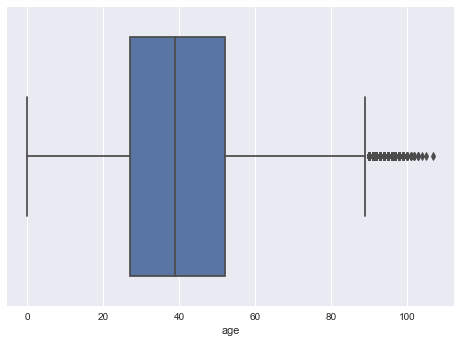

In [724]:
sns.boxplot(df['age'])
plt.show()

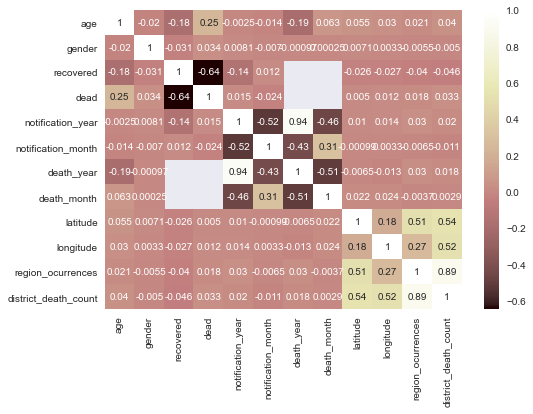

In [725]:
sns.heatmap(dfcorr, annot=True, cmap='pink')
plt.show()

/Users/beelzebruno/.virtualenvs/ml/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='dead', ylabel='count'>

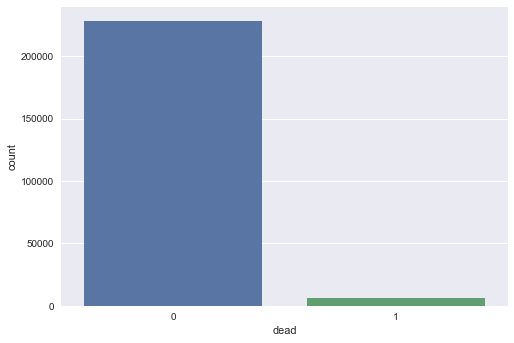

In [726]:
sns.countplot(df['dead'])

/Users/beelzebruno/.virtualenvs/ml/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='notification_year', ylabel='count'>

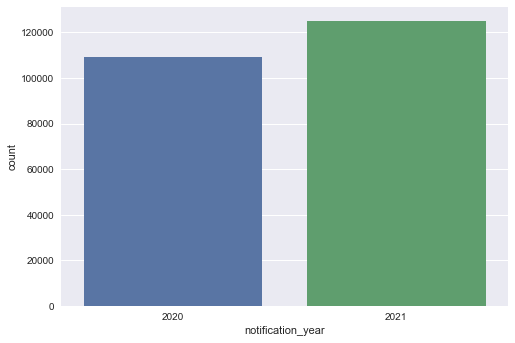

In [727]:
sns.countplot(df['notification_year'])

/Users/beelzebruno/.virtualenvs/ml/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='death_year', ylabel='count'>

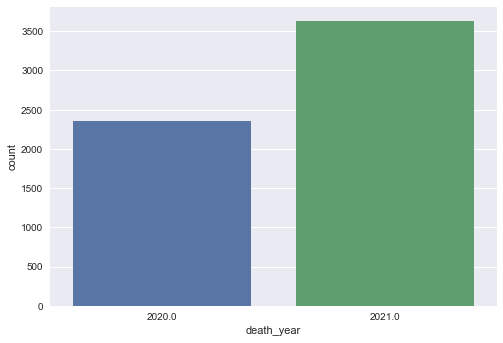

In [728]:
sns.countplot(df['death_year'])

/Users/beelzebruno/.virtualenvs/ml/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='death_month', ylabel='count'>

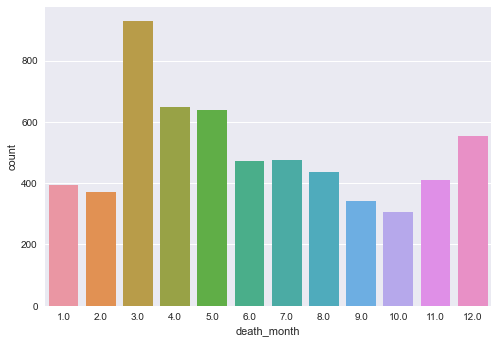

In [729]:
sns.countplot(df['death_month'])

/Users/beelzebruno/.virtualenvs/ml/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='gender', ylabel='count'>

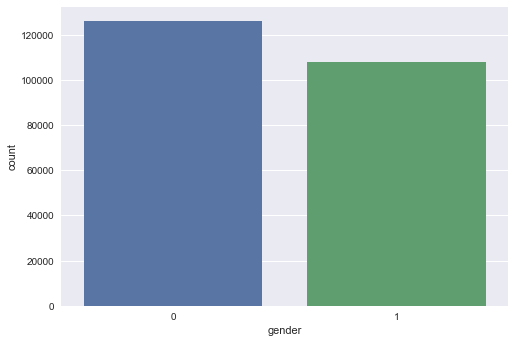

In [730]:
sns.countplot(df['gender'])

<AxesSubplot:ylabel='Frequency'>

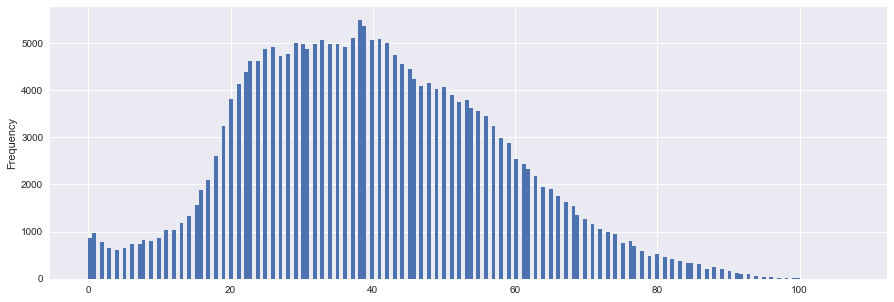

In [747]:
df.age.plot.hist(figsize=(15, 5), bins=200)

<BarContainer object of 11 artists>

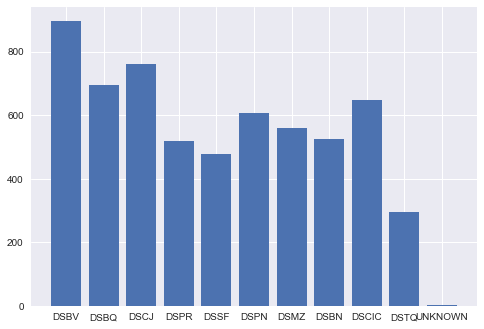

In [749]:
plt.bar(district_death_count.keys(), district_death_count.values())

array([[<AxesSubplot:title={'center':'notification_date'}>,
        <AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'gender'}>,
        <AxesSubplot:title={'center':'death_date'}>],
       [<AxesSubplot:title={'center':'recovered'}>,
        <AxesSubplot:title={'center':'dead'}>,
        <AxesSubplot:title={'center':'notification_year'}>,
        <AxesSubplot:title={'center':'notification_month'}>],
       [<AxesSubplot:title={'center':'notification_day'}>,
        <AxesSubplot:title={'center':'death_year'}>,
        <AxesSubplot:title={'center':'death_month'}>,
        <AxesSubplot:title={'center':'region_ocurrences'}>],
       [<AxesSubplot:title={'center':'district_death_count'}>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

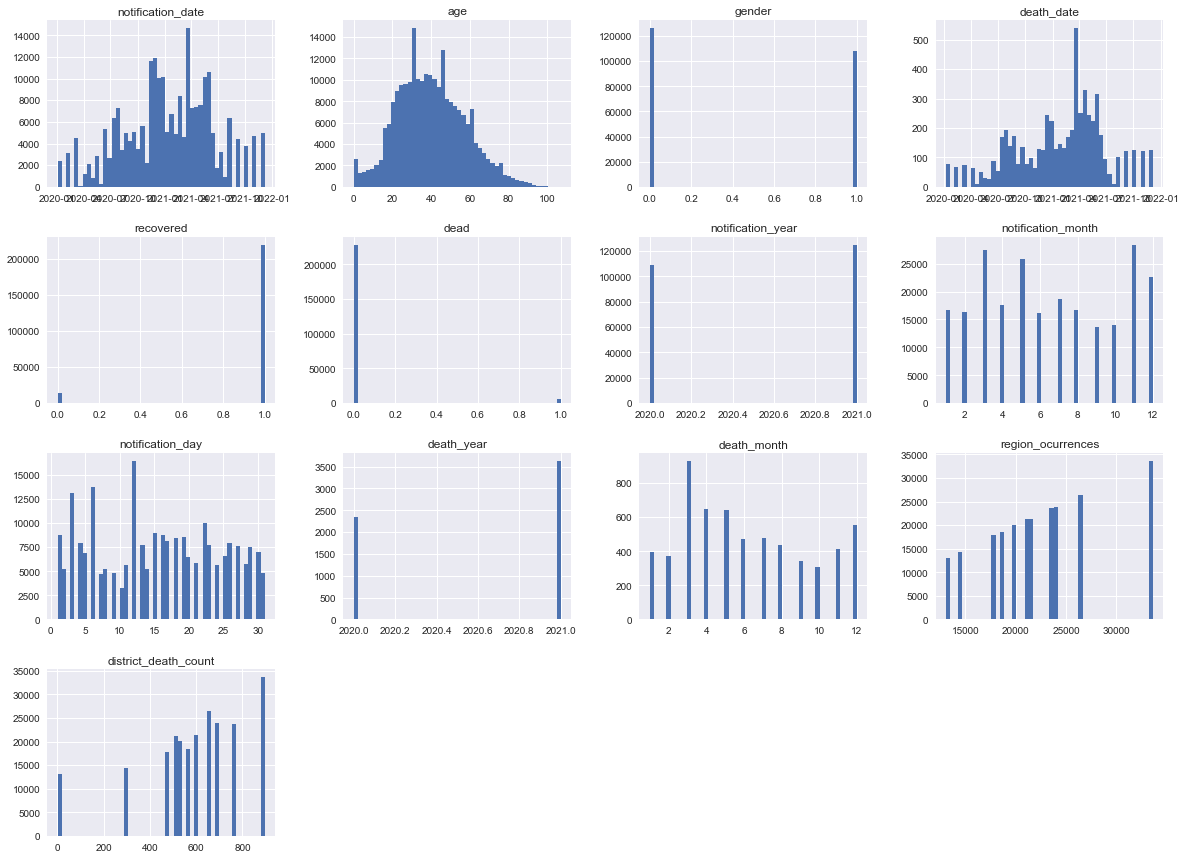

In [746]:
df.hist(bins=50, figsize=(20, 15))

In [ ]:
# https://publicacoes.ifc.edu.br/index.php/metapre/article/view/1312/1020

In [770]:
parsed_df = df[['notification_year', 'notification_month', 'notification_day', 'recovered', 'dead']].copy()
dead_grouped_by_date = {}
infected_grouped_by_date = {}

for data_point in parsed_df.values:
    year, month, day = data_point[0], data_point[1], data_point[2]
    recovered, dead = data_point[3], data_point[4]
    key = f'{day}/{month}/{year}'

    if key in dead_grouped_by_date.keys():
        dead_grouped_by_date[key] += dead
    else:
        dead_grouped_by_date[key] = dead

    if key in infected_grouped_by_date.keys():
        infected_grouped_by_date[key] += 1
    else:
        infected_grouped_by_date[key] = 1


In [771]:
dead_count_avg = pd.DataFrame(dead_grouped_by_date.items(), columns=['date', 'count'])
dead_count_avg['date'] = pd.to_datetime(dead_count_avg.date)
dead_count_avg = dead_count_avg.sort_values(by="date")

infected_count_avg = pd.DataFrame(infected_grouped_by_date.items(), columns=['date', 'count'])
infected_count_avg['date'] = pd.to_datetime(infected_count_avg.date)
infected_count_avg = infected_count_avg.sort_values(by="date")


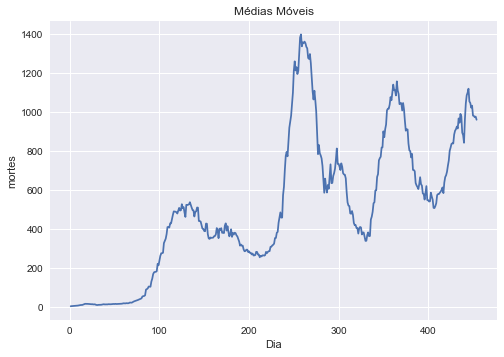

In [772]:
gap = 14
results = []
count = 0
while count < len(infected_count_avg) - gap + 1:
#     if int(str(new_df.date.values[count])[:4]) == 2020:
    group = infected_count_avg['count'].values[count : count + gap]
    group_avg = sum(group) / gap
    results.append(group_avg)

    count +=1

day_month = []
for day in range(1, len(results) + 1):
    day_month.append(day)

# Visualizar gráfico de médias móveis
plt.style.use('seaborn')
plt.xlabel('Dia')
plt.ylabel('mortes')
plt.title('Médias Móveis')

plt.plot(day_month, results)
plt.show()

In [781]:
infected_df = pd.DataFrame({'date': day_month, 'avg': results})
dead_df = pd.DataFrame({'date': day_month, 'avg': results})

In [783]:
infected_df.tail()

,date,avg
449,450,11.500000
450,451,10.785714
451,452,10.357143
452,453,9.928571
453,454,9.714286


In [782]:
dead_df.tail()

,date,avg
449,450,11.500000
450,451,10.785714
451,452,10.357143
452,453,9.928571
453,454,9.714286


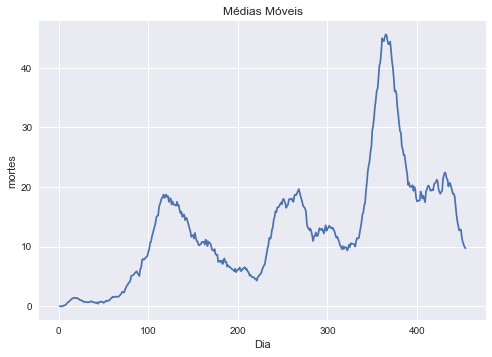

In [780]:
gap = 14
results = []
count = 0
while count < len(dead_count_avg) - gap + 1:
    group = dead_count_avg['count'].values[count : count + gap]
    group_avg = sum(group) / gap
    results.append(group_avg)

    count +=1

day_month = []
for day in range(1, len(results) + 1):
    day_month.append(day)

# Visualizar gráfico de médias móveis
plt.style.use('seaborn')
plt.xlabel('Dia')
plt.ylabel('mortes')
plt.title('Médias Móveis')

plt.plot(day_month, results)
plt.show()

<AxesSubplot:>

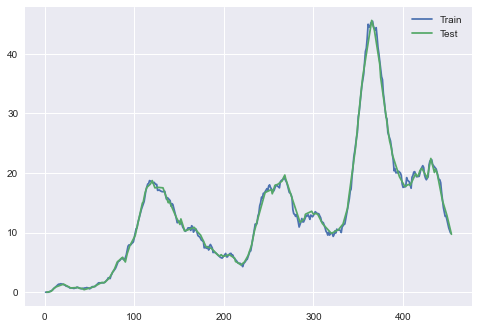

In [797]:
X_train, X_test, y_train, y_test = train_test_split(
    dead_df.date.values,
    dead_df['avg'].values
)

sns.lineplot(x=X_train, y=y_train, label='Train')
sns.lineplot(x=X_test, y=y_test, label='Test')

In [798]:
def display_scores(scores):
    print('Scores: ', scores)
    print('Mean: ', scores.mean())
    print('Std deviation: ', scores.std())

In [828]:
# modelo de base
from sklearn.dummy import DummyRegressor
dr = DummyRegressor()
dr.fit(X_train, y_train)
dummy_preds = dr.predict(X_test)
print(dr.score(X_test, y_test))

-0.005363119056078114


<AxesSubplot:>

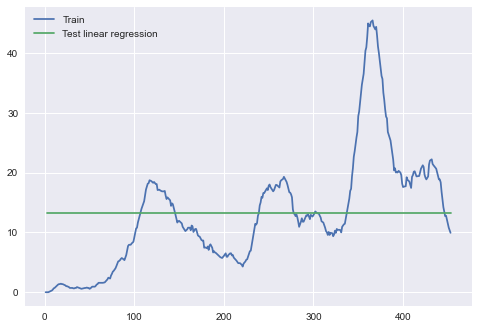

In [827]:
sns.lineplot(x=X_train, y=y_train, label='Train')
sns.lineplot(x=X_test, y=dummy_preds, label='Test linear regression')

In [808]:
lin_reg = LinearRegression()
lin_reg.fit(X_train.reshape(-1, 1), y_train)

predictions = lin_reg.predict(X_test.reshape(-1, 1))
lin_mse = mean_squared_error(y_test, predictions)
lin_rmse = np.sqrt(lin_mse)

lin_reg_scores = cross_val_score(lin_reg, X_test.reshape(-1, 1), y_test,
                         scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-lin_reg_scores)

print(lin_rmse)
display_scores(lin_rmse_scores)

6.643805955825296
Scores:  [4.68926648 8.52839262 9.07887024 4.59810627 6.26359922 4.28876564
 4.86825445 7.2548515  8.15852571 7.55201471]
Mean:  6.528064682747226
Std deviation:  1.7230295200742274


<AxesSubplot:>

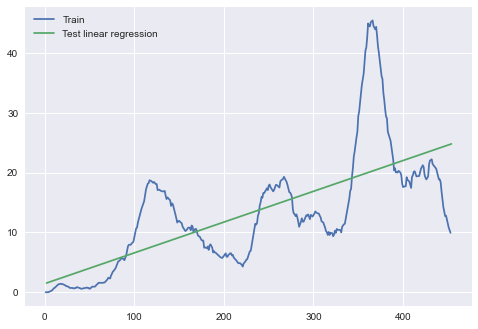

In [819]:
sns.lineplot(x=X_train, y=y_train, label='Train')
sns.lineplot(x=X_test, y=predictions, label='Test linear regression')

In [820]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train.reshape(-1, 1), y_train)

tree_predictions = tree_reg.predict(X_test.reshape(-1, 1))

tree_mse = mean_squared_error(y_test, tree_predictions)
tree_rmse = np.sqrt(tree_mse)

scores = cross_val_score(tree_reg, X_test.reshape(-1, 1), y_test,
                         scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)

print(tree_rmse)
display_scores(tree_rmse_scores)

0.556831093287582
Scores:  [1.37612045 0.89618428 1.5139656  2.71005309 1.40268759 0.70710678
 1.13511991 1.03420176 1.31813384 1.1295902 ]
Mean:  1.3223163495540822
Std deviation:  0.5183803481703873


<AxesSubplot:>

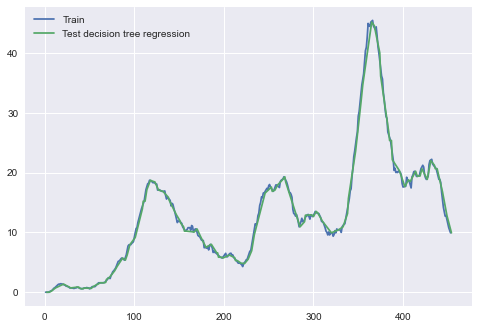

In [821]:
sns.lineplot(x=X_train, y=y_train, label='Train')
sns.lineplot(x=X_test, y=tree_predictions, label='Test decision tree regression')

In [823]:
forest_reg = DecisionTreeRegressor()
forest_reg.fit(X_train.reshape(-1, 1), y_train)
forest_predictions = forest_reg.predict(X_test.reshape(-1, 1))

forest_mse = mean_squared_error(y_test, forest_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_scores = cross_val_score(forest_reg, X_test.reshape(-1, 1), y_test,
                         scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-forest_scores)

print(forest_rmse)
display_scores(tree_rmse_scores)

0.556831093287582
Scores:  [1.37612045 0.89618428 1.5139656  2.71005309 1.40268759 0.70710678
 1.13511991 1.03420176 1.31813384 1.1295902 ]
Mean:  1.3223163495540822
Std deviation:  0.5183803481703873


<AxesSubplot:>

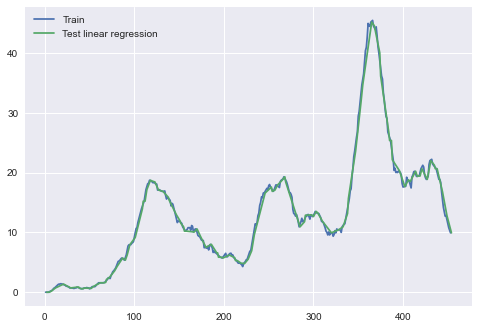

In [824]:
sns.lineplot(x=X_train, y=y_train, label='Train')
sns.lineplot(x=X_test, y=forest_predictions, label='Test linear regression')

In [832]:
svr = SVR()
svr.fit(X_train.reshape(-1, 1), y_train)
svr_preds = svr.predict(X_test.reshape(-1, 1))

print(metrics.r2_score(y_test, svr_preds))
print(svr.score(X_test.reshape(-1, 1), y_test))
print(metrics.mean_absolute_error(y_test, svr_preds))

0.57144951100751
0.57144951100751
3.9739845645662637


<AxesSubplot:>

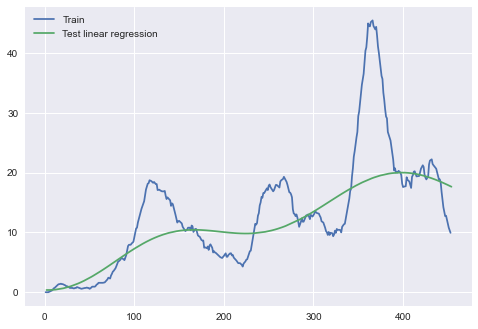

In [833]:
sns.lineplot(x=X_train, y=y_train, label='Train')
sns.lineplot(x=X_test, y=svr_preds, label='Test linear regression')

In [869]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(
    activation='logistic',
    learning_rate_init=0.01,
    random_state=1, max_iter=500).fit(X_train.reshape(-1, 1), y_train)
mlp_preds = mlp.predict(X_test.reshape(-1, 1))

print(metrics.r2_score(y_test, mlp_preds))
print(svr.score(X_test.reshape(-1, 1), y_test))
print(metrics.mean_absolute_error(y_test, mlp_preds))

0.4900608802952813
0.57144951100751
4.7871005700429885


<AxesSubplot:>

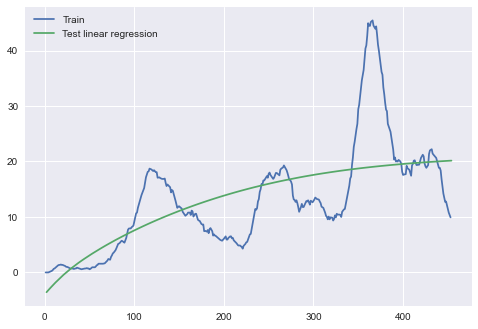

In [870]:
sns.lineplot(x=X_train, y=y_train, label='Train')
sns.lineplot(x=X_test, y=mlp_preds, label='Test linear regression')

In [871]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('std_scaler', StandardScaler())
])
transformed_X_train = num_pipeline.fit_transform(X_train.reshape(-1, 1))
transformed_X_test = num_pipeline.fit_transform(X_test.reshape(-1, 1))

transformed_y_train = num_pipeline.fit_transform(y_train.reshape(-1, 1))
transformed_y_test = num_pipeline.fit_transform(y_test.reshape(-1, 1))

In [892]:
%%capture
param_grid = [{'n_jobs': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100]}]
grid_search = GridSearchCV(lin_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(transformed_X_train, transformed_y_train)

In [893]:
grid_search.best_params_

{'n_jobs': 1}

In [894]:
lin_reg = LinearRegression(n_jobs=1)
lin_reg.fit(transformed_X_train, transformed_y_train)

predictions = lin_reg.predict(transformed_X_test)
lin_mse = mean_squared_error(transformed_y_test, predictions)
lin_rmse = np.sqrt(lin_mse)

lin_reg_scores = cross_val_score(lin_reg, transformed_X_test, transformed_y_test,
                         scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-lin_reg_scores)

print(lin_rmse)
display_scores(lin_rmse_scores)

0.706677076778711
Scores:  [0.49903673 0.90760063 0.96618304 0.48933537 0.6665789  0.45641501
 0.51808482 0.77206902 0.86823899 0.80369345]
Mean:  0.6947235955479992
Std deviation:  0.18336663645274442


<AxesSubplot:>

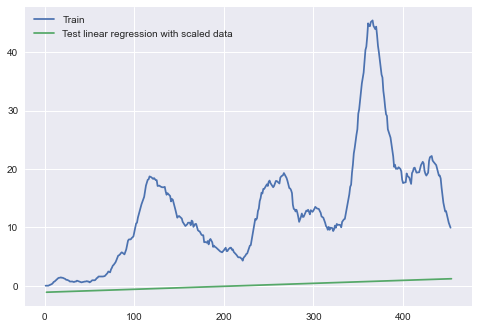

In [903]:
sns.lineplot(x=X_train, y=y_train, label='Train')
sns.lineplot(x=X_test, y=predictions.reshape(-1),
             label='Linear regression with scaled data')

In [910]:
%%capture
param_grid = [
    {
        'C': [2.0, 2.1, 2.2, 2.5, 2.7, 3.0, 4.0, 5.0, 50],
        'degree': [-1, 1, 1.5, 2, 3, 4, 5],
        'epsilon': [0.1, 0.2, 0.3, 0.5, 0.7]
    },
]

grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(transformed_X_train2, transformed_y_train2)

In [911]:
grid_search.best_params_

{'C': 50, 'degree': 1, 'epsilon': 0.3}

In [913]:
svr = SVR(C=50, degree=1, epsilon=0.3).fit(transformed_X_train, transformed_y_train)
svr_preds = svr.predict(transformed_X_test)

print(metrics.r2_score(transformed_y_test, svr_preds))
print(svr.score(transformed_X_test, transformed_y_test))
print(metrics.mean_absolute_error(transformed_y_test, svr_preds))

0.7006550130094017
0.7006550130094017
0.39374774013978586


/Users/beelzebruno/.virtualenvs/ml/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


<AxesSubplot:>

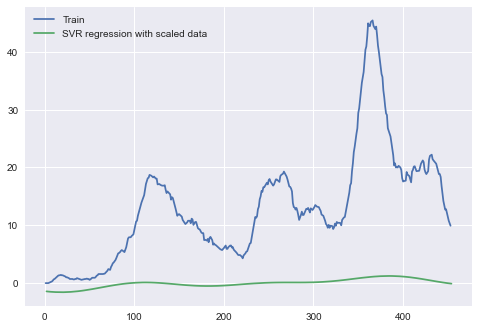

In [916]:
sns.lineplot(x=X_train, y=y_train, label='Train')
sns.lineplot(x=X_test, y=svr_preds,
             label='SVR regression with scaled data')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    dead_df.date.values,
    dead_df['avg'].values
)

sns.lineplot(x=X_train, y=y_train, label='Train')
sns.lineplot(x=X_test, y=y_test, label='Test')

In [ ]:
lin_reg.fit(X_train.reshape(-1, 1), y_train)
y = lin_reg.predict(np.arange(0, 700).reshape(-1, 1))
ry = forest_reg.fit(X_train.reshape(-1, 1), y_train).predict(np.arange(0, 700).reshape(-1, 1))


In [ ]:
forest_reg = DecisionTreeRegressor()
forest_reg.fit(X_train.reshape(-1, 1), y_train)
forest_predictions = forest_reg.predict(X_test.reshape(-1, 1))

forest_mse = mean_squared_error(y_test, forest_predictions)
forest_rmse = np.sqrt(forest_mse)
print(forest_rmse)

forest_scores = cross_val_score(forest_reg, X_test.reshape(-1, 1), y_test,
                         scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-forest_scores)
display_scores(tree_rmse_scores)

<AxesSubplot:>

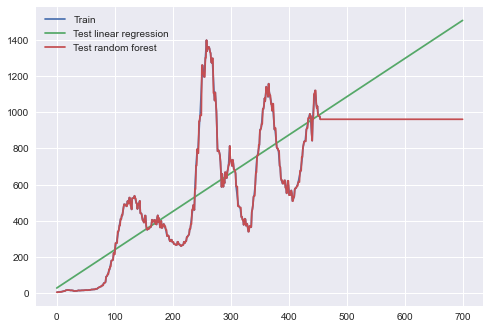

In [461]:
X_train, X_test, y_train, y_test = train_test_split(
    infected_df.date.values,
    infected_df['avg'].values
)

lin_reg.fit(X_train.reshape(-1, 1), y_train)
y = lin_reg.predict(np.arange(0, 700).reshape(-1, 1))
ry = forest_reg.fit(X_train.reshape(-1, 1), y_train).predict(np.arange(0, 700).reshape(-1, 1))

sns.lineplot(x=X_train, y=y_train, label='Train')
sns.lineplot(x=np.arange(0, 700), y=y, label='Test linear regression')
sns.lineplot(x=np.arange(0, 700), y=ry, label='Test random forest')

In [462]:
lin_reg_scores = cross_val_score(lin_reg, X_test.reshape(-1, 1), y_test,
                         scoring='neg_mean_squared_error', cv=25)
lin_rmse_scores = np.sqrt(-lin_reg_scores)
display_scores(lin_rmse_scores)

Scores:  [309.83083763 128.51563212 178.04837526 148.77581101 128.48267378
 182.97367183 155.2215971  276.01730492 334.4478625  154.85018566
 186.88879983 145.00237248 196.55754161 214.96467269 114.56010614
 375.54348293 147.0661266  367.7065706   42.33324003 342.48542424
 193.76380257 468.07856338 421.42705817 235.5019608  140.23334412]
Mean:  223.57108071984433
Std deviation:  106.41344342062466


In [463]:
forest_reg = DecisionTreeRegressor()
forest_reg.fit(X_train.reshape(-1, 1), y_train)
forest_predictions = forest_reg.predict(X_test.reshape(-1, 1))

forest_mse = mean_squared_error(y_test, forest_predictions)
forest_rmse = np.sqrt(forest_mse)
print(forest_rmse)

forest_scores = cross_val_score(forest_reg, X_test.reshape(-1, 1), y_test,
                         scoring='neg_mean_squared_error', cv=25)
tree_rmse_scores = np.sqrt(-forest_scores)
display_scores(tree_rmse_scores)

34.42637772626153
Scores:  [ 73.27263877  21.89872329  70.90553503  10.12710044  30.62668571
  14.34306346  21.87774473  43.61236952  35.94867373  45.77351074
 156.68746678  28.86812026  25.96380919  43.96196176  30.17284392
  67.80661653  48.12850835  33.99377194  44.07902516  74.89392158
  14.37831594 117.11133069  30.47661365  10.7846499   44.24922172]
Mean:  45.597688911157995
Std deviation:  33.08167275220086


In [468]:
lr = LinearRegression(fit_intercept=True, n_jobs=1)
lr.fit(X_train.reshape(-1, 1), y_train)
lr.score(X_test.reshape(-1, 1), y_test)

0.5245932704579475

In [557]:
rf = RandomForestRegressor()
rf.fit(X_train.reshape(-1, 1), y_train)
rf.score(X_test.reshape(-1, 1), y_test)

0.9942622132101089

In [561]:
metrics.mean_absolute_error(transformed_y_test, rf.predict(X_test.reshape(-1, 1)))

1.411545700819115

In [829]:
from sklearn.svm import SVR

In [476]:
from sklearn import metrics
lr_preds = lr.predict(X_test.reshape(-1, 1))
metrics.r2_score(y_test, lr_preds)

0.5245932704579475

In [478]:
metrics.mean_absolute_error(y_test, lr_preds)

184.5660974496745

In [660]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('std_scaler', StandardScaler())
])
transformed_X_train = num_pipeline.fit_transform(X_train.reshape(-1, 1))
transformed_X_test = num_pipeline.fit_transform(X_test.reshape(-1, 1))

transformed_y_train = num_pipeline.fit_transform(y_train.reshape(-1, 1))
transformed_y_test = num_pipeline.fit_transform(y_test.reshape(-1, 1))

In [548]:

lr = LinearRegression().fit(transformed_X_train, transformed_y_train)
lr_preds = lr.predict(transformed_X_test)
metrics.r2_score(transformed_y_test, lr_preds)

0.5301059144135094

In [552]:
metrics.mean_absolute_error(transformed_y_test, lr_preds)

0.5184476903292682

In [559]:
rf = RandomForestRegressor().fit(transformed_X_train, transformed_y_train)
rf_preds = rf.predict(transformed_X_test)
metrics.r2_score(transformed_y_test, rf_preds)

<ipython-input-559-07178310120a>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestRegressor().fit(transformed_X_train, transformed_y_train)


0.15887889082633955

In [560]:
metrics.mean_absolute_error(transformed_y_test, rf_preds)

0.6901676121158667

In [662]:
svr = SVR().fit(transformed_X_train, transformed_y_train)
svr_preds = svr.predict(transformed_X_test)
svr.score(transformed_y_test, svr_preds)

/Users/beelzebruno/.virtualenvs/ml/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


-0.1419561270647114

In [686]:
%%capture
param_grid = [
    {'n_estimators': [3, 10, 30]},
    {'bootstrap': [False], 'n_estimators': [3, 10]}
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(transformed_X_train, transformed_y_train)

In [566]:
grid_search.best_params_

{'n_estimators': 30}

In [567]:
rf = RandomForestRegressor(n_estimators=30).fit(transformed_X_train, transformed_y_train)
rf_preds = rf.predict(transformed_X_test)
metrics.r2_score(transformed_y_test, rf_preds)

<ipython-input-567-d52a6ee12736>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestRegressor(n_estimators=30).fit(transformed_X_train, transformed_y_train)


0.1619618654079127

In [682]:
%%capture
# supress output
param_grid = [
    {
        'C': [2.0, 2.1, 2.2, 2.5, 2.7, 3.0, 4.0, 5.0, 50],
        'degree': [-1, 1, 1.5, 2, 3, 4, 5],
        'epsilon': [0.1, 0.2, 0.3, 0.5, 0.7]
    },
]

grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(transformed_X_train, transformed_y_train)

In [683]:
grid_search.best_params_

{'C': 50, 'degree': 1, 'epsilon': 0.3}

In [671]:
svr = SVR(C=50, degree=1, epsilon=0.3)
svr.fit(transformed_X_train, transformed_y_train)
svr_preds = svr.predict(transformed_X_test)
svr.score(transformed_y_test, svr_preds)

/Users/beelzebruno/.virtualenvs/ml/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.5558824571041618

In [665]:
param_grid = [{'n_jobs': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100]}]

grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(transformed_X_train, transformed_y_train)

GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid=[{'n_jobs': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50,
                                     100]}],
             scoring='neg_mean_squared_error')

In [616]:
grid_search.best_params_

{'n_jobs': 1}

<AxesSubplot:>

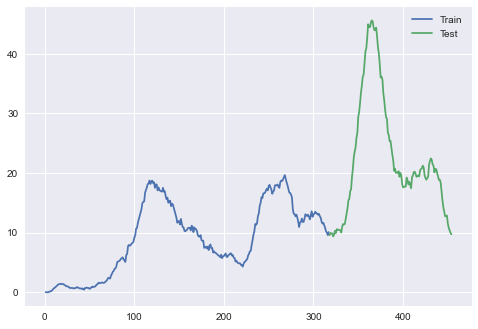

In [766]:
X = dead_df['date'].values
y = dead_df['avg'].values

train_length = int(len(dead_df)*0.7)
test_length = len(dead_df) - train_length

X_train = X[0:train_length]
y_train = y[0:train_length]

X_test = X[train_length:len(dead_df)]
y_test = y[train_length:len(dead_df)]

sns.lineplot(x=X_train, y=y_train, label='Train')
sns.lineplot(x=X_test, y=y_test, label='Test')

In [646]:
#### 
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('std_scaler', StandardScaler())
])
transformed_X_train2 = num_pipeline.fit_transform(X_train.reshape(-1, 1))
transformed_X_test2 = num_pipeline.fit_transform(X_test.reshape(-1, 1))

transformed_y_train2 = num_pipeline.fit_transform(y_train.reshape(-1, 1))
transformed_y_test2 = num_pipeline.fit_transform(y_test.reshape(-1, 1))


In [647]:
lr = LinearRegression().fit(transformed_X_train2, transformed_y_train2)
lr_preds = lr.predict(transformed_X_test2)
print(metrics.r2_score(transformed_y_test2, lr_preds))
print(metrics.mean_absolute_error(transformed_y_test2, lr_preds))

0.5752754476278636
0.49335373975141383


In [648]:
rf = RandomForestRegressor().fit(transformed_X_train2, transformed_y_train2)
rf_preds = rf.predict(transformed_X_test2)
print(metrics.r2_score(transformed_y_test2, rf_preds))
print(metrics.mean_absolute_error(transformed_y_test2, rf_preds))

<ipython-input-648-a6c54ac13574>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestRegressor().fit(transformed_X_train2, transformed_y_train2)


0.30169986877972443
0.5376625696772128


In [651]:
svr = SVR().fit(transformed_X_train2, transformed_y_train2)
svr_preds = rf.predict(transformed_X_test2)
print(svr.score(transformed_y_test2, svr_preds))
print(metrics.mean_absolute_error(transformed_y_test2, svr_preds))

-0.020441550731586267
0.5376625696772128


/Users/beelzebruno/.virtualenvs/ml/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [675]:
%%capture  # supress output
param_grid = [
    {'n_estimators': [3, 10, 30]},
    {'bootstrap': [False], 'n_estimators': [3, 10]}
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(transformed_X_train2, transformed_y_train2)

In [676]:
grid_search.best_params_

{'n_estimators': 30}

In [654]:
rf = RandomForestRegressor(n_estimators=10).fit(transformed_X_train2, transformed_y_train2)
rf_preds = rf.predict(transformed_X_test2)
print(metrics.r2_score(transformed_y_test2, rf_preds))
print(metrics.mean_absolute_error(transformed_y_test2, rf_preds))

0.3021899649310167
0.539165758878812


<ipython-input-654-07b2278ac782>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestRegressor(n_estimators=10).fit(transformed_X_train2, transformed_y_train2)


In [677]:
%%capture  # supress output
param_grid = [
    {
        'C': [2.0, 2.1, 2.2, 2.5, 2.7, 3.0, 4.0, 5.0, 50],
        'degree': [-1, 1, 1.5, 2, 3, 4, 5],
        'epsilon': [0.1, 0.2, 0.3, 0.5, 0.7]
    },
]

grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(transformed_X_train2, transformed_y_train2)

UsageError: unrecognized arguments: supress output


In [656]:
grid_search.best_params_

{'C': 50, 'degree': 1, 'epsilon': 0.3}

In [659]:
svr = SVR(C=50, degree=1, epsilon=0.3).fit(transformed_X_train2, transformed_y_train2)
svr_preds = rf.predict(transformed_X_test2)
print(svr.score(transformed_y_test2, svr_preds))
print(metrics.mean_absolute_error(transformed_y_test2, svr_preds))

0.26536617455882094
0.539165758878812


/Users/beelzebruno/.virtualenvs/ml/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


<AxesSubplot:>

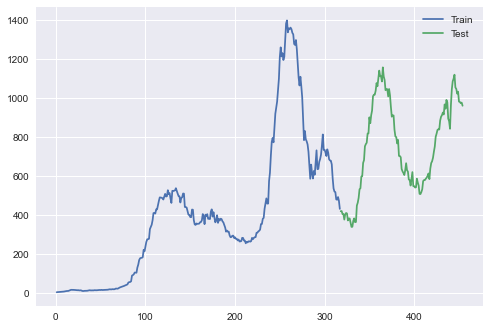

In [767]:
X = infected_df['date'].values
y = infected_df['avg'].values

train_length = int(len(infected_df)*0.7)
test_length = len(infected_df) - train_length

X_train = X[0:train_length]
y_train = y[0:train_length]

X_test = X[train_length:len(infected_df)]
y_test = y[train_length:len(infected_df)]

sns.lineplot(x=X_train, y=y_train, label='Train')
sns.lineplot(x=X_test, y=y_test, label='Test')